# Here we check the approximation of samples to the full data in the shap Explainer.

In [331]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [288]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_15000\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [289]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [290]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [291]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [292]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [293]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [294]:
data = data.sample(n=50000)

In [295]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    35049
1     4951
Name: count, dtype: int64
Test label
0    8754
1    1246
Name: count, dtype: int64


In [296]:
train_sample = X_train.sample(n=1000)
train_sample_tensor = torch.tensor(train_sample.values, dtype=torch.float32)
test_sample = X_test.sample(n=1000)
test_sample_tensor = torch.tensor(test_sample.values, dtype=torch.float32)

In [297]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [298]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 313/313 [00:08<00:00, 39.11batch/s]


Epoch [1/5], Train Loss: 0.0301, Train Acc: 0.9879, Train F1: 0.9865


Epoch 2/5: 100%|██████████| 313/313 [00:07<00:00, 41.54batch/s]


Epoch [2/5], Train Loss: 0.0149, Train Acc: 0.9921, Train F1: 0.9921


Epoch 3/5: 100%|██████████| 313/313 [00:07<00:00, 40.95batch/s]


Epoch [3/5], Train Loss: 0.0141, Train Acc: 0.9929, Train F1: 0.9928


Epoch 4/5: 100%|██████████| 313/313 [00:07<00:00, 41.42batch/s]


Epoch [4/5], Train Loss: 0.0137, Train Acc: 0.9932, Train F1: 0.9931


Epoch 5/5: 100%|██████████| 313/313 [00:07<00:00, 39.62batch/s]


Epoch [5/5], Train Loss: 0.0125, Train Acc: 0.9934, Train F1: 0.9933


Testing: 100%|██████████| 79/79 [00:00<00:00, 243.70batch/s]


Test Loss: 0.0169, Test Accuracy: 0.9914, Test F1: 0.9912


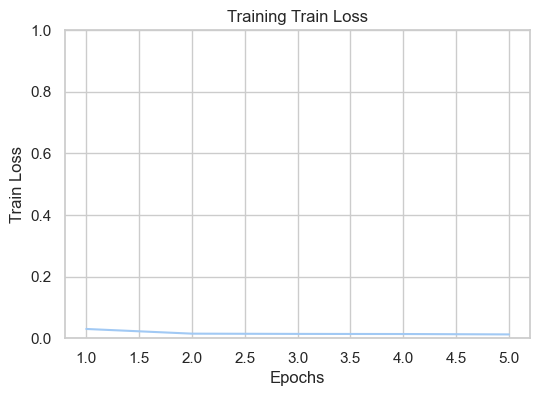

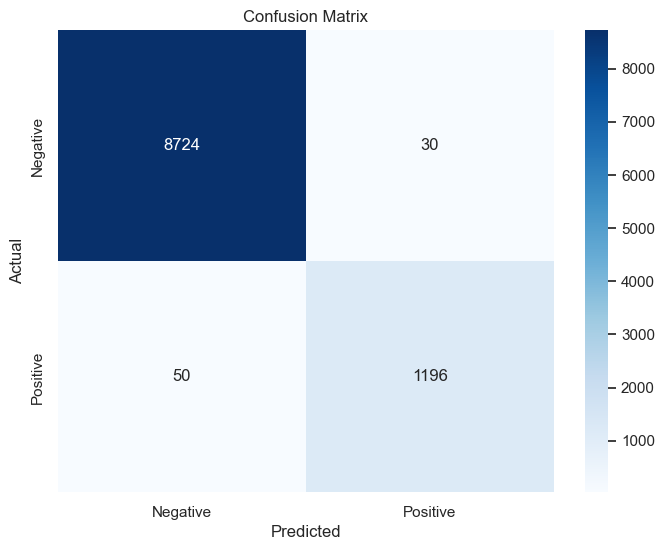

In [299]:
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.01
epochs = 5
save_factor = 100
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

# Difference in test and train background for sampling methods.
Deep Explainer gives us more precise shapely values

# Check Sample
Note: The true sampled training set happens in the training run and a real background can be made by modifying the Dynamic Neural Network model to give it the option to store the dataset.

In [300]:
# 38.7 min
xp1 = shap.DeepExplainer(model1, X_test_tensor)
shap1 = xp1.shap_values(X_test_tensor)

In [ ]:
# 5.4 min
xp2 = shap.DeepExplainer(model1, test_sample_tensor)
shap2 = xp2.shap_values(X_test_tensor)

# Check standard model

In [302]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 313/313 [00:03<00:00, 98.76batch/s] 


Epoch [1/5], Train Loss: 0.0339, Train Acc: 0.9857, Train F1: 0.9840


Epoch 2/5: 100%|██████████| 313/313 [00:03<00:00, 103.04batch/s]


Epoch [2/5], Train Loss: 0.0180, Train Acc: 0.9911, Train F1: 0.9910


Epoch 3/5: 100%|██████████| 313/313 [00:03<00:00, 101.04batch/s]


Epoch [3/5], Train Loss: 0.0165, Train Acc: 0.9919, Train F1: 0.9918


Epoch 4/5: 100%|██████████| 313/313 [00:03<00:00, 102.25batch/s]


Epoch [4/5], Train Loss: 0.0160, Train Acc: 0.9921, Train F1: 0.9920


Epoch 5/5: 100%|██████████| 313/313 [00:03<00:00, 97.43batch/s] 


Epoch [5/5], Train Loss: 0.0151, Train Acc: 0.9928, Train F1: 0.9928


Testing: 100%|██████████| 79/79 [00:00<00:00, 161.84batch/s]


Test Loss: 0.0184, Test Accuracy: 0.9895, Test F1: 0.9891


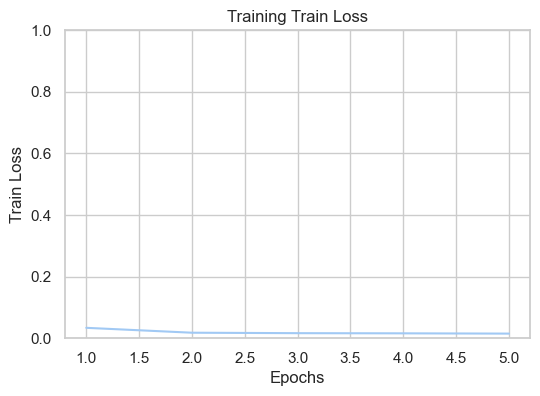

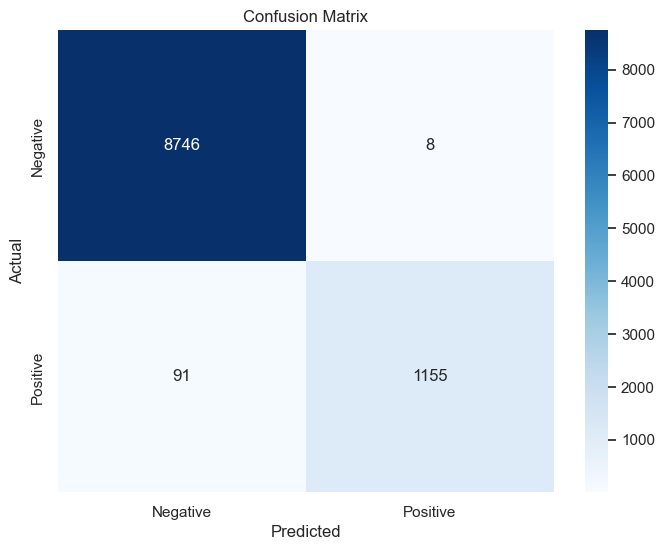

In [303]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
save_factor = 100
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model2.train_loss, len(model2.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
# 36.3 min
xp3 = shap.DeepExplainer(model2, X_test_tensor)
shap3 = xp3.shap_values(X_test_tensor)

In [ ]:
# 119.4 min
xp4 = shap.DeepExplainer(model2, X_train_tensor)
shap4 = xp4.shap_values(X_test_tensor)

In [ ]:
# 2.6 min
xp5 = shap.DeepExplainer(model2, train_sample_tensor)
shap5 = xp5.shap_values(X_test_tensor)

In [ ]:
# 2.6 min
xp6 = shap.DeepExplainer(model2, test_sample_tensor)
shap6 = xp6.shap_values(X_test_tensor)

# Random Forest does not hold additivity property due to averaging the baseline. Shifted to XGBoost model.

In [332]:
rf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9911


In [ ]:
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9917


In [ ]:
# 9.1 seconds
xp_rf1 = shap.TreeExplainer(rf1, X_test)
shap_rf1 = xp_rf1.shap_values(X_test, check_additivity=False)

In [ ]:
# 12.4 seconds
xp_xgb1 = shap.TreeExplainer(xgb, X_test)
shap_xgb1 = xp_xgb1.shap_values(X_test)

 95%|=================== | 9495/10000 [00:12<00:00]       

In [ ]:
# 12.3 seconds
xp_xgb2 = shap.TreeExplainer(xgb, X_train)
shap_xgb2 = xp_xgb2.shap_values(X_test)

 95%|=================== | 9454/10000 [00:12<00:00]       

In [ ]:
# 12.3 seconds
xp_xgb3 = shap.TreeExplainer(xgb, train_sample)
shap_xgb3 = xp_xgb3.shap_values(X_test)

 98%|===================| 9815/10000 [00:13<00:00]        

In [ ]:
# 12.8 seconds
xp_xgb4 = shap.TreeExplainer(xgb, test_sample)
shap_xgb4 = xp_xgb4.shap_values(X_test)

 95%|=================== | 9525/10000 [00:13<00:00]       

# Evaluation

Select non-sparse data

In [347]:
cols = [225, 40, 16, 11, 211, 224, 271, 31, 32, 13]

In [348]:
names = X_train[X_train.columns[[225, 40, 16, 11, 211, 224, 271, 31, 32, 13]]].columns
print(names)

Index(['state_CON', 'proto_tcp', 'dmeansz', 'swin', 'service_none',
       'state_FIN', 'sport_1043', 'ct_srv_src', 'ct_srv_dst', 'stcpb'],
      dtype='object')


Neural Network

Sampled

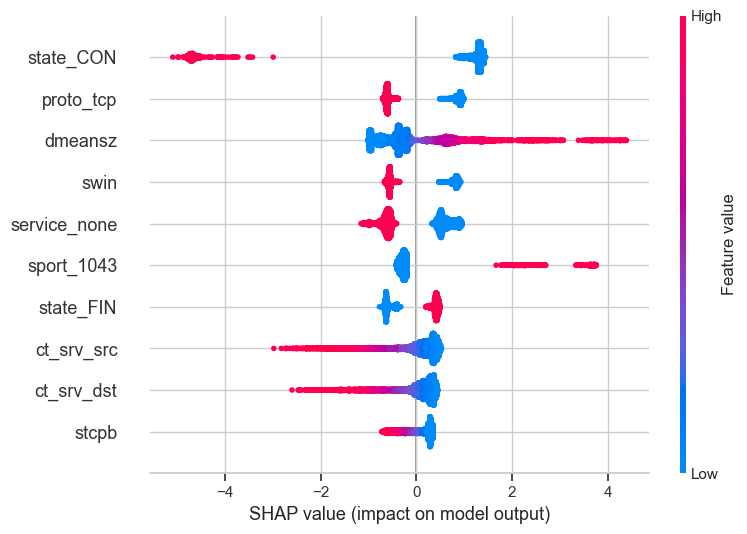

In [349]:
shap.summary_plot(shap1.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

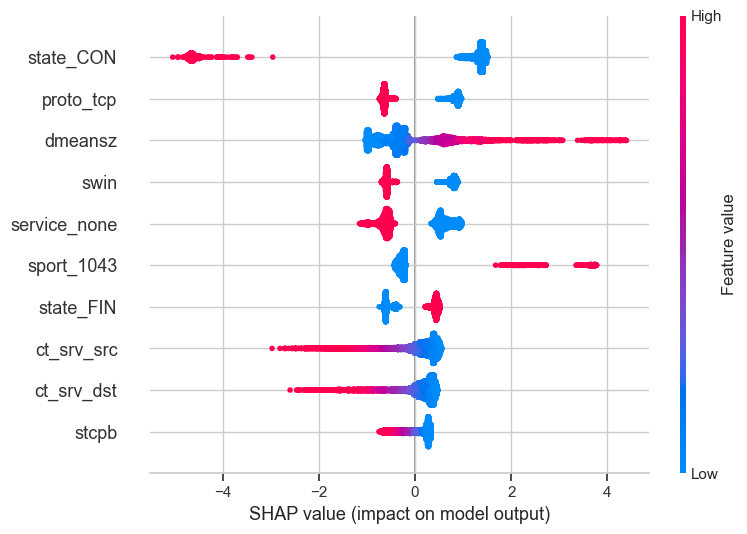

In [350]:
shap.summary_plot(shap2.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

Standard

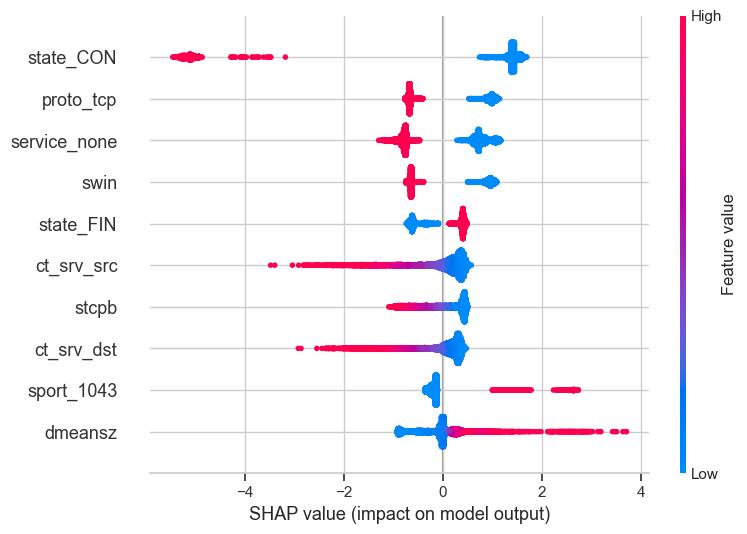

In [354]:
shap.summary_plot(shap3.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

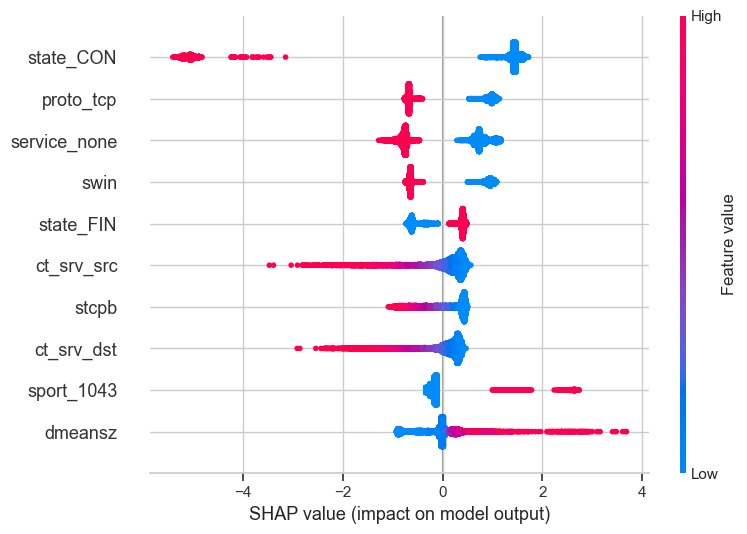

In [355]:
shap.summary_plot(shap4.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

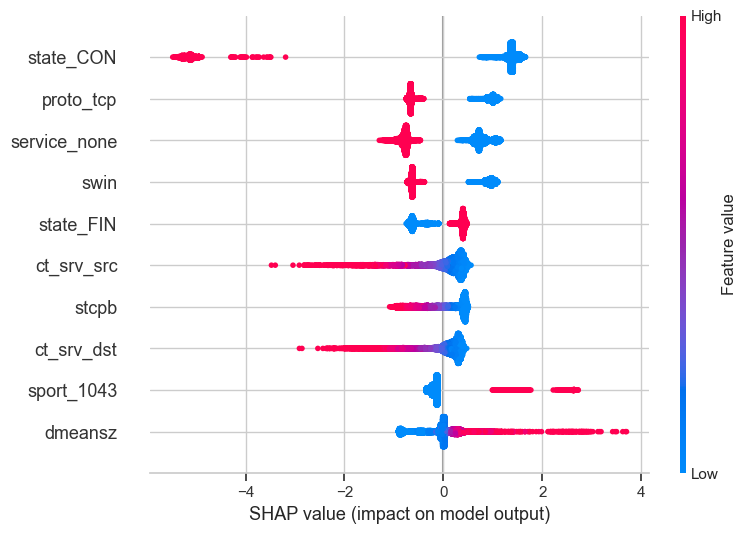

In [356]:
shap.summary_plot(shap5.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

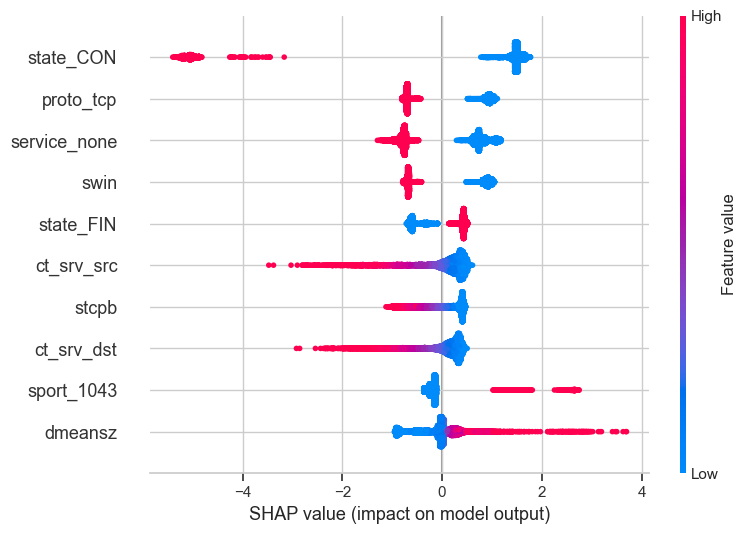

In [357]:
shap.summary_plot(shap6.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

Random Forest

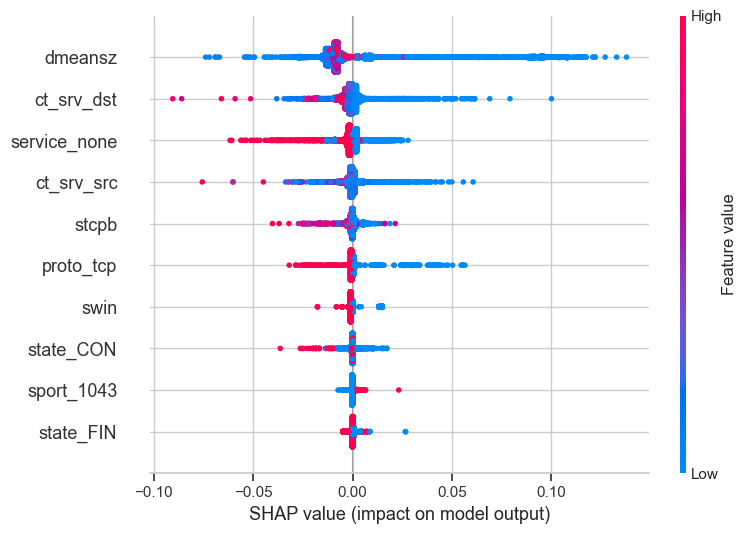

In [358]:
shap.summary_plot(shap_rf1[:, :, 1][:, cols], X_test.iloc[:, cols])

XGBoost

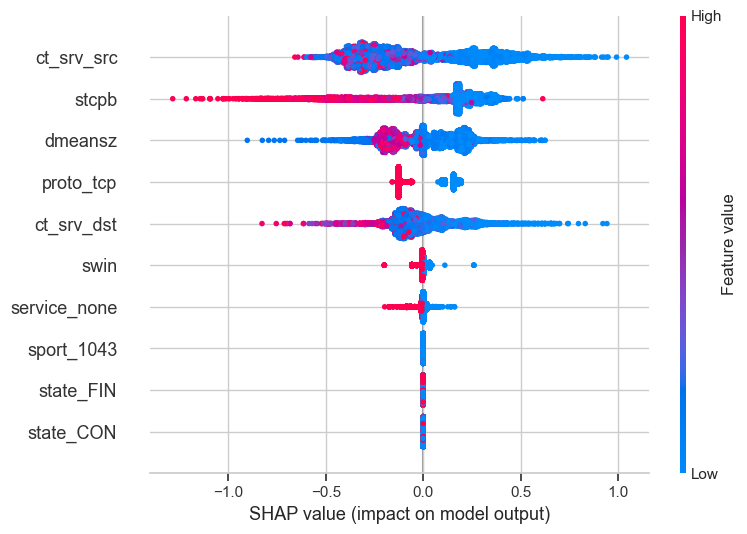

In [ ]:
# Interestingly we get a probability output same as a Sigmoid meaning it is valid as a teacher model.
shap.summary_plot(shap_xgb1[:, :][:, cols], X_test.iloc[:, cols])

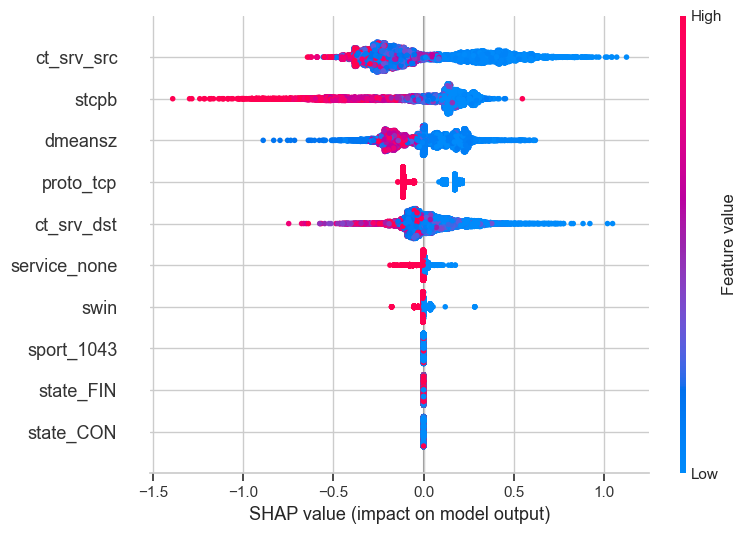

In [361]:
shap.summary_plot(shap_xgb2[:, :][:, cols], X_test.iloc[:, cols])

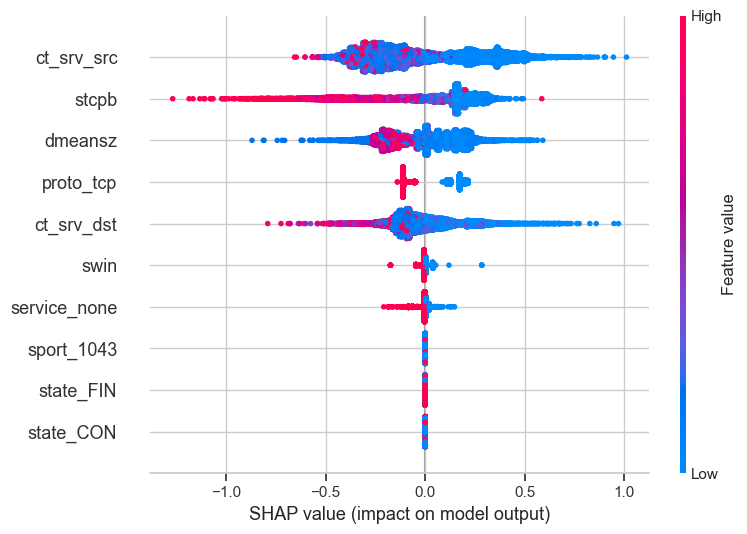

In [362]:
shap.summary_plot(shap_xgb3[:, :][:, cols], X_test.iloc[:, cols])

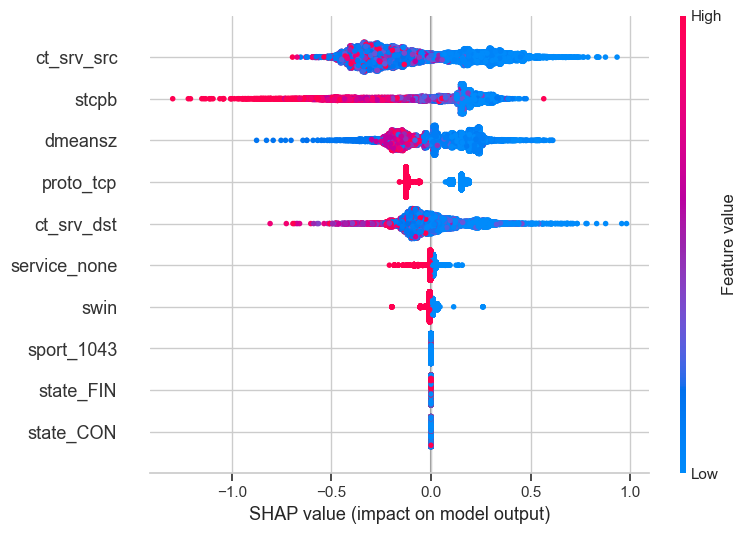

In [376]:
shap.summary_plot(shap_xgb4[:, :][:, cols], X_test.iloc[:, cols])

 Sparse Data

In [364]:
cols2 = [217, 175, 251, 8, 180, 43, 274, 186, 254, 6]
names2 = X_train[X_train.columns[[217, 175, 251, 8, 180, 43, 274, 186, 254, 6]]].columns
print(names)

Index(['state_CON', 'proto_tcp', 'dmeansz', 'swin', 'service_none',
       'state_FIN', 'sport_1043', 'ct_srv_src', 'ct_srv_dst', 'stcpb'],
      dtype='object')


Neural Network

Sampled

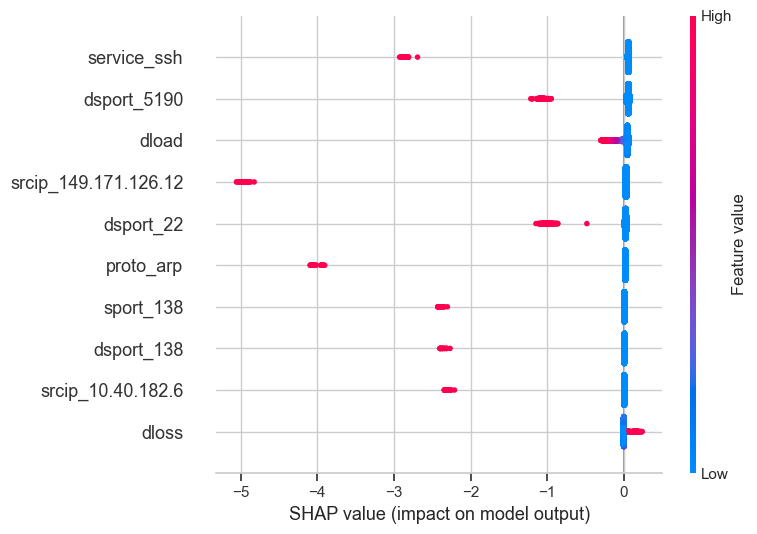

In [365]:
shap.summary_plot(shap1.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

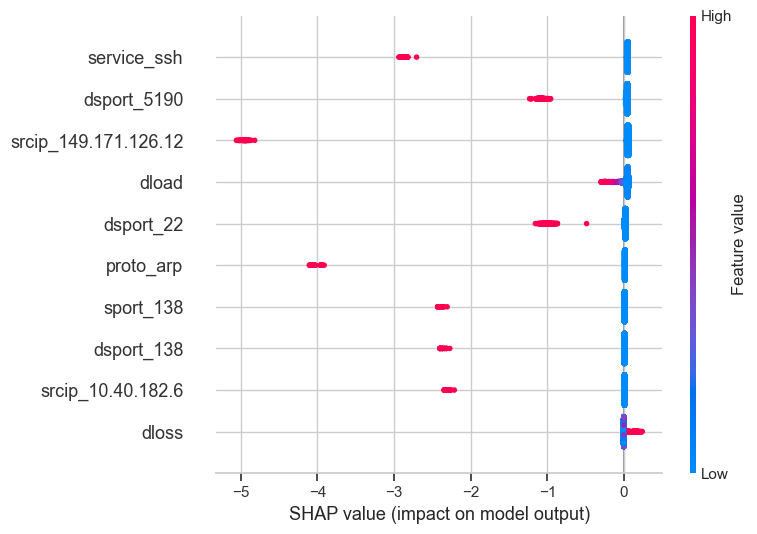

In [366]:
shap.summary_plot(shap2.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

Standard

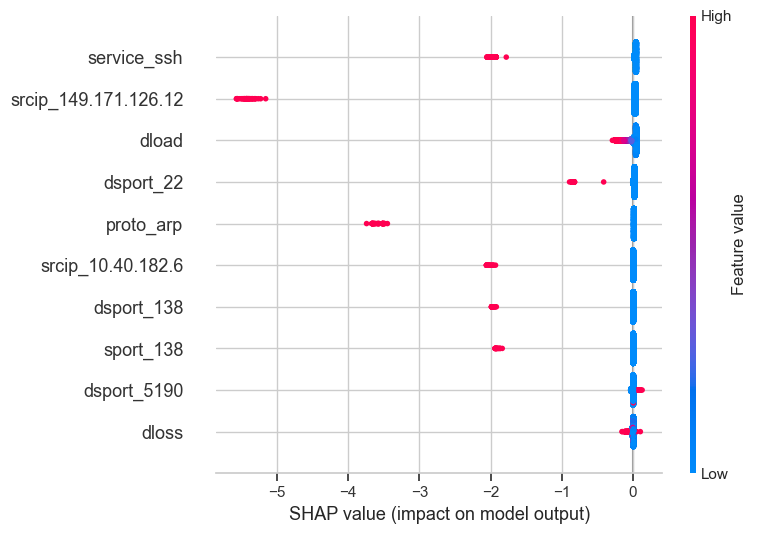

In [367]:
shap.summary_plot(shap3.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

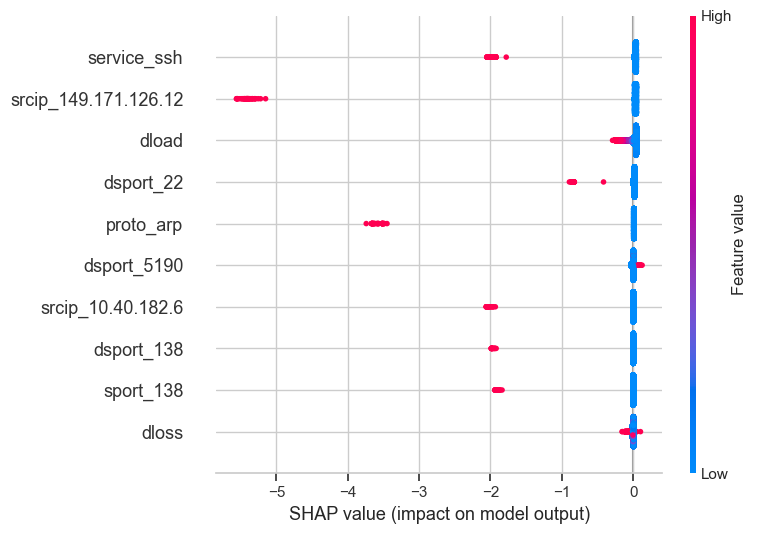

In [368]:
shap.summary_plot(shap4.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

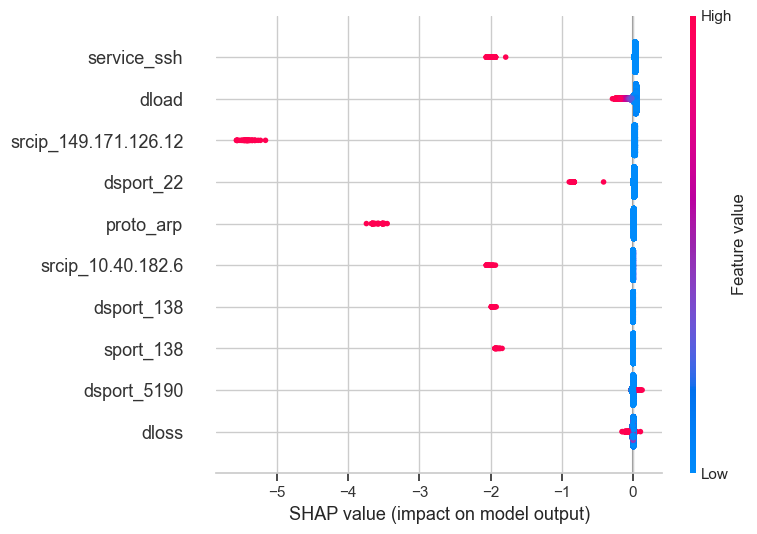

In [369]:
shap.summary_plot(shap5.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

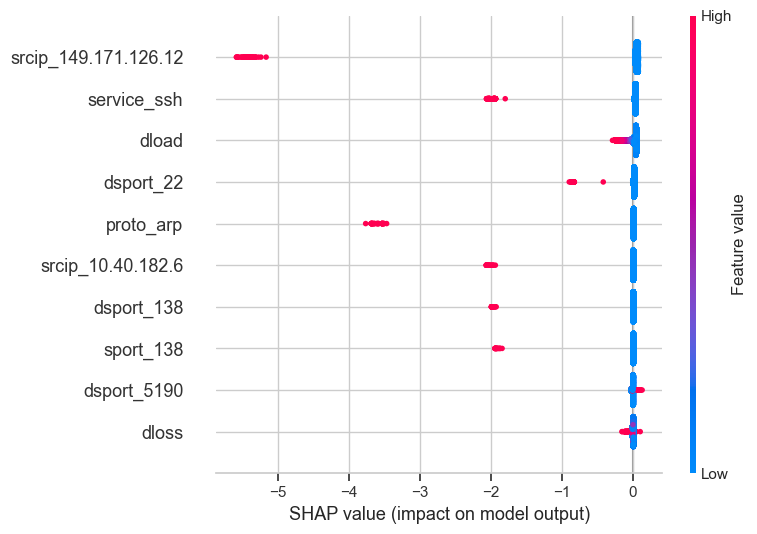

In [370]:
shap.summary_plot(shap6.squeeze()[:, cols2], X_test_tensor[:, cols2], feature_names=names2)

Random Forest

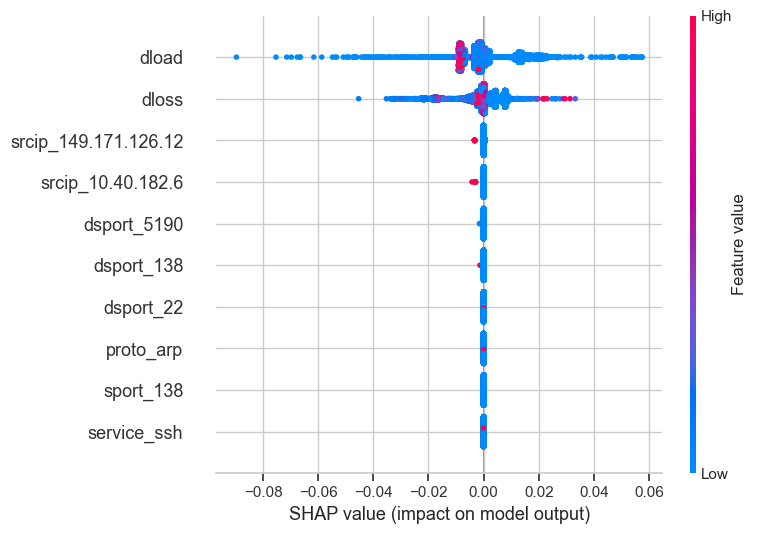

In [371]:
shap.summary_plot(shap_rf1[:, :, 1][:, cols2], X_test.iloc[:, cols2])

XGBoost

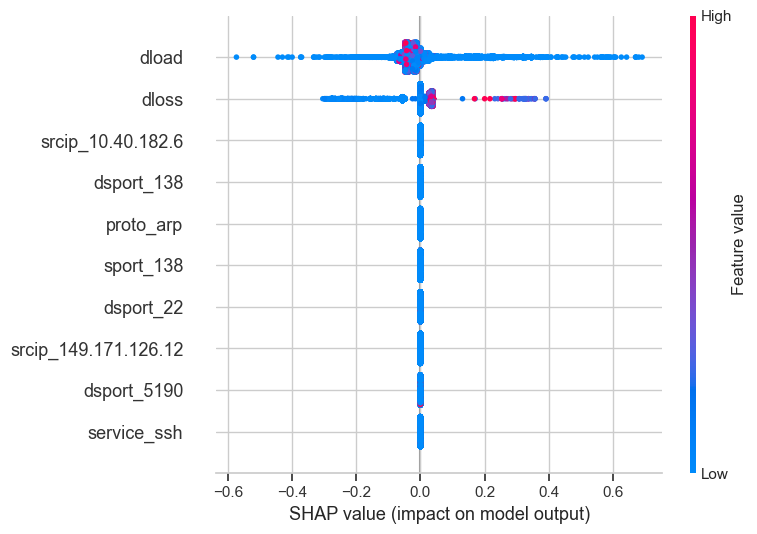

In [373]:
shap.summary_plot(shap_xgb1[:, :][:, cols2], X_test.iloc[:, cols2])

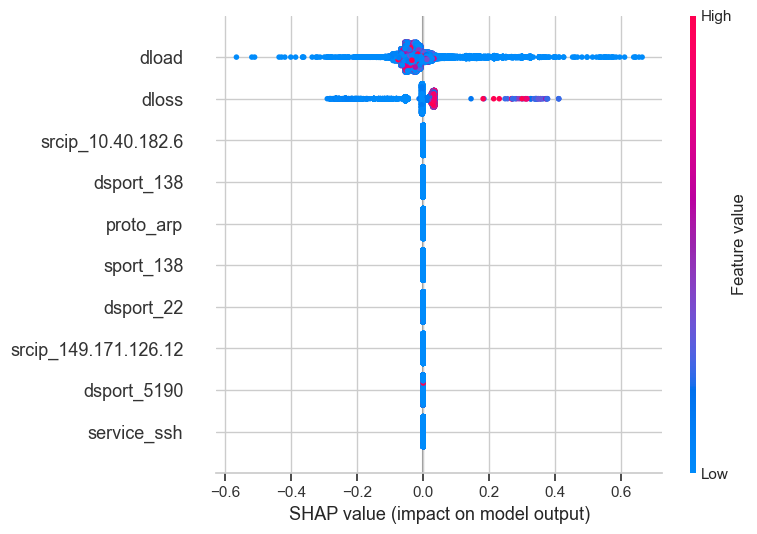

In [374]:
shap.summary_plot(shap_xgb2[:, :][:, cols2], X_test.iloc[:, cols2])

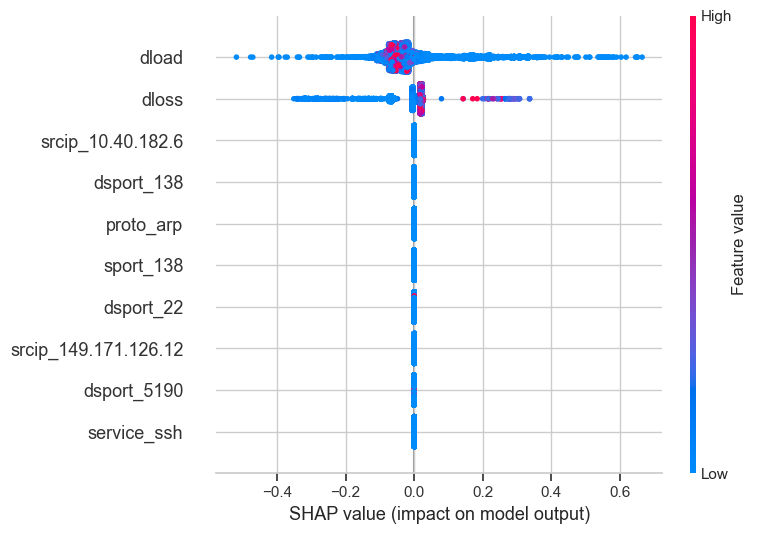

In [375]:
shap.summary_plot(shap_xgb3[:, :][:, cols2], X_test.iloc[:, cols2])

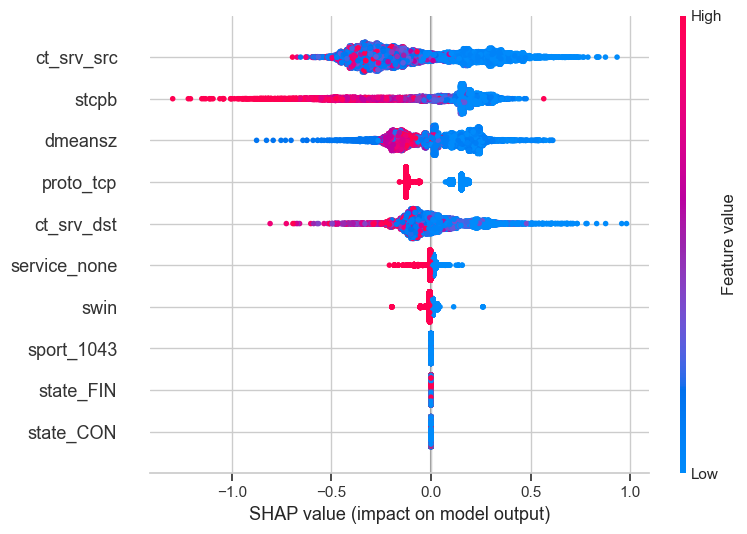

In [377]:
shap.summary_plot(shap_xgb4[:, :][:, cols], X_test.iloc[:, cols])

Quick Test to compare value counts in the full train and sampled train

In [ ]:
# This is no good we might need a bigger sample. - Still the same with bigger sample.
# What does this mean?
# It means that our sampled train data generalises well to the whole train data as background but when using the test set for shap
# we may get extra static representations in shap even though this might not be the case in the trained model.
list = []
for i in X_train.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in train_sample.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))

25
25


Full test and sampled test

In [ ]:
list = []
for i in X_test.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in test_sample.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))

102
102


# What about train to test though?

In [ ]:
# Ok good we have the difference here so the test is valid when using train background and test shap.
list = []
for i in X_train.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in X_test.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))

25
102
